In [1]:
import torch
from torch import nn

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
device

'cuda'

In [4]:
from zipfile import ZipFile
import requests
from pathlib import Path
import os

data_path = Path("data")
image_path = data_path / "pizza_steak_sushi"

if image_path.is_dir() :
    print("Folder already exist,no need to download")
else:
    data_path.mkdir(parents=True,exist_ok=True)
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        print("Downloading data...")
        res = requests.get(
            "https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip"
        )
        f.write(res.content)

    with ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zf:
        print("Extract file...")
        zf.extractall(image_path)

    os.remove(data_path / "pizza_steak_sushi.zip")

Folder already exist,no need to download


In [5]:
train_dir = image_path / "train"
test_dir = image_path / "test"

In [6]:
import os

for dirpath,dirnames,filenames in os.walk(train_dir):
    print(f"on {dirpath} has {len(dirnames)} directories and {len(filenames)} files")

on data\pizza_steak_sushi\train has 3 directories and 0 files
on data\pizza_steak_sushi\train\pizza has 0 directories and 154 files
on data\pizza_steak_sushi\train\steak has 0 directories and 146 files
on data\pizza_steak_sushi\train\sushi has 0 directories and 150 files


In [7]:
## Manual Transforms
from torchvision.transforms import v2

from torchvision.transforms.functional import InterpolationMode


manual_transforms = v2.Compose(

    [

        v2.ToImage(),

        v2.Resize(size=(256, 256), interpolation=InterpolationMode.BICUBIC),

        v2.CenterCrop(size=(224, 224)),

        v2.ToDtype(dtype=torch.float32, scale=True),

        v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),

    ]
)

In [8]:
## Auto Transforms
from torchvision.models.efficientnet import EfficientNet_B0_Weights

weights  = EfficientNet_B0_Weights.DEFAULT

weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [9]:
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [10]:
BATCH_SIZE = 32

In [11]:
from going_modular.data_setup import create_dataloaders

train_dataloader, test_dataloader, class_names = create_dataloaders(
    train_dir, test_dir, manual_transforms, auto_transforms, BATCH_SIZE
)

len(train_dataloader)

15

In [12]:
from torchvision.models.efficientnet import efficientnet_b0,EfficientNet_B0_Weights

weights = EfficientNet_B0_Weights.DEFAULT
model = efficientnet_b0(weights=weights).to(device=device)

In [13]:
from torchinfo import summary

summary(
    model=model,
    input_size=(BATCH_SIZE, 3, 224, 224),
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=15,
    row_settings=["var_names"],
)

Layer (type (var_name))                                      Input Shape     Output Shape    Param #         Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224] [32, 1000]      --              True
├─Sequential (features)                                      [32, 3, 224, 224] [32, 1280, 7, 7] --              True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224] [32, 32, 112, 112] --              True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224] [32, 32, 112, 112] 864             True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112] [32, 32, 112, 112] 64              True
│    │    └─SiLU (2)                                         [32, 32, 112, 112] [32, 32, 112, 112] --              --
│    └─Sequential (1)                                        [32, 32, 112, 112] [32, 16, 112, 112] --              True
│    │    └─MBConv (0)                              

In [14]:
for param in model.features.parameters():
    param.requires_grad = False

In [15]:
summary(
    model,
    input_size=(BATCH_SIZE, 3, 224, 224),
    col_names=["input_size", "output_size", "num_params", "trainable"],
    row_settings=["var_names"],
)

Layer (type (var_name))                                      Input Shape               Output Shape              Param #                   Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]         [32, 1000]                --                        Partial
├─Sequential (features)                                      [32, 3, 224, 224]         [32, 1280, 7, 7]          --                        False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]         [32, 32, 112, 112]        --                        False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]         [32, 32, 112, 112]        (864)                     False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]        [32, 32, 112, 112]        (64)                      False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]        [32, 32, 112, 112]        --         

In [16]:
from torch import nn

torch.manual_seed(42)
torch.cuda.manual_seed(42)


model.classifier = nn.Sequential(
    nn.Dropout(p=0.2,inplace=True),
    nn.Linear(in_features=1280, out_features=len(class_names), bias=True)
).to(device)

model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=3, bias=True)
)

In [17]:
summary(
    model,
    input_size=(BATCH_SIZE, 3, 224, 224),
    col_names=["input_size", "output_size", "num_params", "trainable"],
)

Layer (type:depth-idx)                                  Input Shape               Output Shape              Param #                   Trainable
EfficientNet                                            [32, 3, 224, 224]         [32, 3]                   --                        Partial
├─Sequential: 1-1                                       [32, 3, 224, 224]         [32, 1280, 7, 7]          --                        False
│    └─Conv2dNormActivation: 2-1                        [32, 3, 224, 224]         [32, 32, 112, 112]        --                        False
│    │    └─Conv2d: 3-1                                 [32, 3, 224, 224]         [32, 32, 112, 112]        (864)                     False
│    │    └─BatchNorm2d: 3-2                            [32, 32, 112, 112]        [32, 32, 112, 112]        (64)                      False
│    │    └─SiLU: 3-3                                   [32, 32, 112, 112]        [32, 32, 112, 112]        --                        --
│    └─Sequential

In [18]:
from torchmetrics.classification import Accuracy

loss_fn = nn.CrossEntropyLoss()
acc_fn = Accuracy(task="multiclass",num_classes=len(class_names)).to(device)
optimizer = torch.optim.Adam(params=model.parameters(),lr=0.001)

c:\Coding\python-projects\pytorch-db\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [19]:
from going_modular.engine import train_model

torch.manual_seed(42)
torch.cuda.manual_seed(42)

results = train_model(model,train_dataloader,test_dataloader,loss_fn,acc_fn,optimizer,device,5)



Epoch: 0


Training:   0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.9809 | Train Acc: 0.5933
Test Loss: 0.6760 | Test Acc: 0.8467

Epoch: 1


Train Loss: 0.7335 | Train Acc: 0.8044
Test Loss: 0.5765 | Test Acc: 0.8800

Epoch: 2


Train Loss: 0.6016 | Train Acc: 0.8556
Test Loss: 0.4850 | Test Acc: 0.8867

Epoch: 3


Train Loss: 0.5056 | Train Acc: 0.8689
Test Loss: 0.4465 | Test Acc: 0.8867

Epoch: 4


Train Loss: 0.4902 | Train Acc: 0.8933
Test Loss: 0.4088 | Test Acc: 0.9000


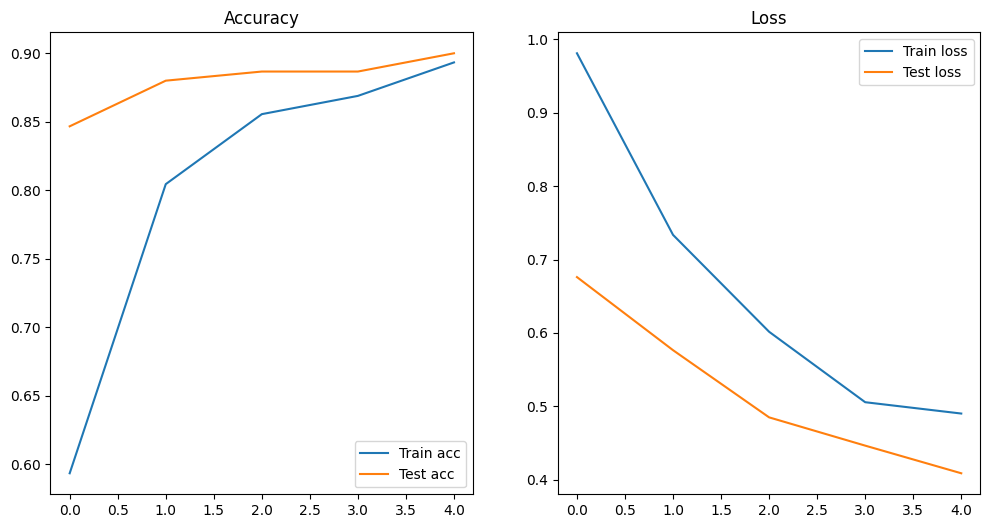

In [20]:
from going_modular.utils import plot_results
plot_results(results)

In [21]:
from going_modular.engine import train_model

torch.manual_seed(42)
torch.cuda.manual_seed(42)

results_train_longer = train_model(
    model, train_dataloader, test_dataloader, loss_fn, acc_fn, optimizer, device, 5
)


Epoch: 0


Train Loss: 0.3758 | Train Acc: 0.8911
Test Loss: 0.3951 | Test Acc: 0.8933

Epoch: 1


Train Loss: 0.3695 | Train Acc: 0.8911
Test Loss: 0.3759 | Test Acc: 0.8933

Epoch: 2


Train Loss: 0.3769 | Train Acc: 0.9156
Test Loss: 0.3462 | Test Acc: 0.9067

Epoch: 3


Train Loss: 0.3233 | Train Acc: 0.9311
Test Loss: 0.3375 | Test Acc: 0.9133

Epoch: 4


Train Loss: 0.3543 | Train Acc: 0.9289
Test Loss: 0.3237 | Test Acc: 0.9200


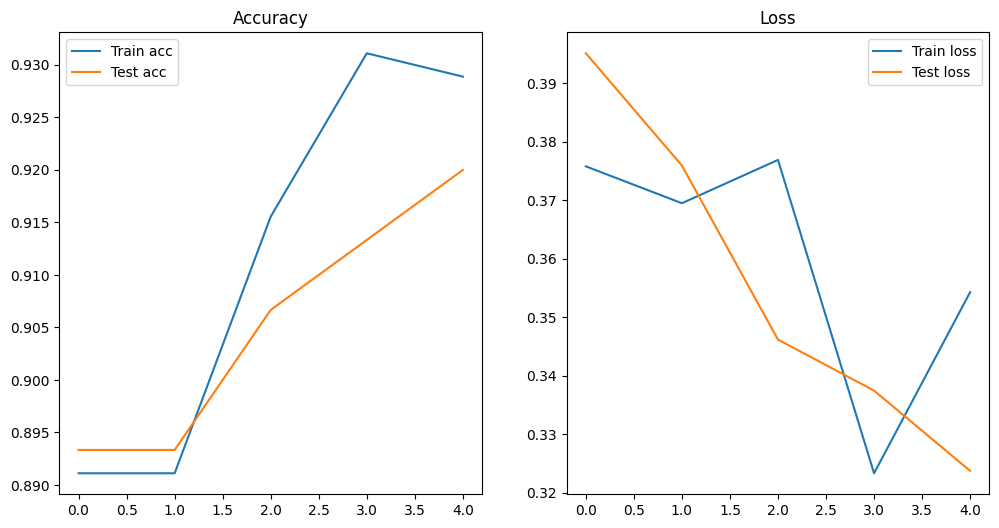

In [22]:
from going_modular.utils import plot_results

plot_results(results_train_longer)

In [23]:
from typing import List,Tuple
import torchvision
from PIL import Image
from torchvision.transforms.functional import InterpolationMode
import matplotlib.pyplot as plt

def plot_and_pred_image(model:nn.Module,class_names:str,image_path:str,image_size:Tuple[int,int]=(224,224),transforms:torchvision.transforms=auto_transforms,device:str=device):
    img = Image.open(image_path)

    if transforms is not None:
        image_transforms = transforms
    else:
        image_transforms = v2.Compose(
            [
                v2.ToImage(),
                v2.Resize(size=(256, 256), interpolation=InterpolationMode.BICUBIC),
                v2.CenterCrop(size=image_size),
                v2.ToDtype(
                    torch.float32,
                    scale=True,
                ),
                v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ]
        )

    model.to(device)

    model.eval()
    with torch.inference_mode():
        transformed_image = image_transforms(img).unsqueeze(dim=0).to(device)

        y_logit = model(transformed_image)
        y_prob = torch.softmax(y_logit,dim=1)
        y_label = y_prob.argmax()

        plt.figure()
        plt.title(f"{class_names[y_label]} | Prob: {y_prob.max():.3f}")
        plt.imshow(img)
        plt.axis(False)

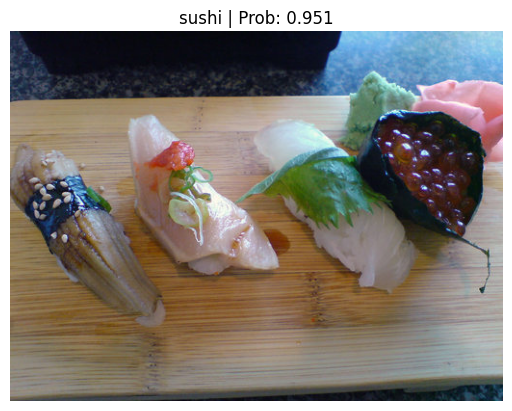

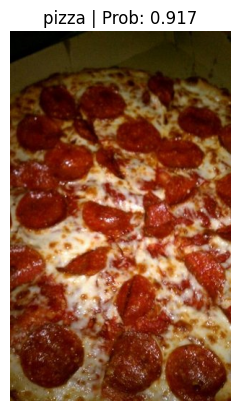

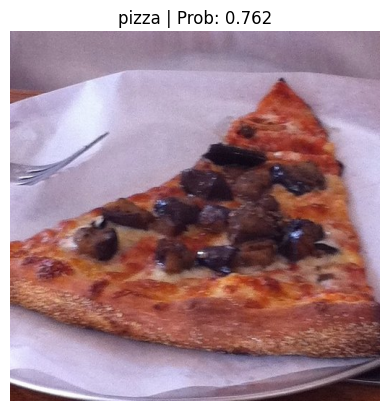

In [24]:
import random

num_images_to_plot = 3
test_image_path_list = list(
    Path(test_dir).glob("*/*.jpg")
)
test_image_path_sample = random.sample(
    population=test_image_path_list,
    k=num_images_to_plot,
)


for image_path in test_image_path_sample:
    plot_and_pred_image(
        model=model,
        image_path=image_path,
        image_size=(224, 224),
        class_names=class_names,
        transforms=auto_transforms,
    )

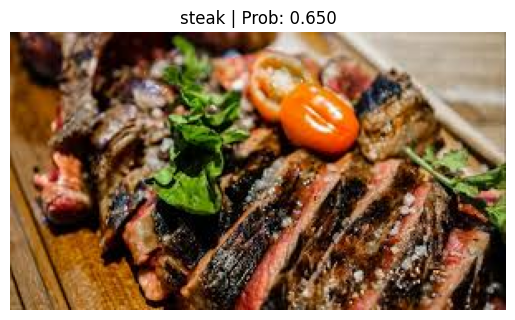

In [26]:
plot_and_pred_image(
        model=model,
        image_path=Path("data/steak.jpg"),
        image_size=(224, 224),
        class_names=class_names,
        transforms=auto_transforms,
    )